<a href="https://colab.research.google.com/github/OmarGIT9880/Omar-Python-Portfollio/blob/main/Accessibility_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Accessibility Analysis: POI Access in Columbus-Cincinnati Corridor**
##Name: Omar Ali
##Date: December 6, 2025
##Overview
Healthcare accessibility analysis using OSM POI data. Aggregated 9 healthcare
types (hospitals, clinics, doctors, pharmacies, dentists, medical offices,
healthcare centers, health food, medical supply) into Healthcare_Services
super-type. Grid: 0.5 mile cells, search radius: 2 miles.


##Summary of Results:
1. Total POI types: 342
2. Healthcare POIs: 620
3. Brute-force: 14.79s, k-D tree: 11.88s
4. Maps: both methods identical
5. Best accessibility: 1 cell with 28 POIs
6. Low accessibility: 56609 cells (≤3 POIs)

##Setup and imports


In [ ]:
!rm -rf geom indexing
!git clone https://github.com/gisalgs/geom.git
!git clone https://github.com/gisalgs/indexing.git

import sys
sys.path.append('geom')
sys.path.append('indexing')

from geom.point import Point
from geom.lcc import spcs_ohio_south
from indexing.kdtree2b import kdtree, range_query_circular
import requests
import json
import matplotlib.pyplot as plt
import math
import time

# Load POI data
url = 'https://raw.githubusercontent.com/gisalgs/data/refs/heads/master/some_ohio_pois_osm.geojson'
poi_data = json.loads(requests.get(url).text)

Cloning into 'geom'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 378 (delta 29), reused 5 (delta 1), pack-reused 314 (from 1)
Receiving objects: 100% (378/378), 100.06 KiB | 5.56 MiB/s, done.
Resolving deltas: 100% (206/206), done.
Cloning into 'indexing'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 180 (delta 2), reused 0 (delta 0), pack-reused 170 (from 1)
Receiving objects: 100% (180/180), 61.16 KiB | 3.60 MiB/s, done.
Resolving deltas: 100% (94/94), done.


##Question 1: Counting POI types
Count the total number of different POI types in the dataset using a dictionary.

In [ ]:
poi_types = {}

for feature in poi_data['features']:
    poi_type = feature['properties']['poi_type']
    if poi_type not in poi_types:
        poi_types[poi_type] = 1
    else:
        poi_types[poi_type] += 1

print(f"Question 1: Total number of types = {len(poi_types)}")
print(f"\nAll types and their counts:")
for t in sorted(poi_types.keys()):
    print(f"  {t}: {poi_types[t]}")

Question 1: Total number of types = 342

All types and their counts:
  Cincinnati Sell House: 1
  Home Cleaning: 1
  Junk Removal Springfield: 1
  Medical Offices: 1
  Municipal Building: 1
  Smoke_Shop: 1
  Wholesale_Screen_Printer: 1
  agrarian: 4
  air_filling: 1
  alcohol: 72
  alcohol;tobacco: 1
  amphitheater: 1
  animal_boarding: 7
  animal_breeding: 1
  animal_shelter: 2
  animal_training: 3
  antiques: 24
  appliance: 8
  art: 21
  art;frame: 2
  art_school: 1
  arts_centre: 13
  atm: 190
  atv: 1
  baby_goods: 4
  bag: 5
  bakery: 78
  bank: 196
  bar: 293
  bathroom_furnishing: 3
  bbq: 70
  beauty: 301
  bed: 38
  bell: 2
  bench: 2493
  beverages: 67
  bicycle: 41
  bicycle_parking: 684
  bicycle_rental: 169
  bicycle_repair_station: 87
  biergarten: 3
  boat_parts: 1
  boat_rental: 8
  boat_storage: 1
  books: 48
  boutique: 3
  brewing_supplies: 2
  bureau_de_change: 2
  bus_station: 5
  butcher: 15
  cafe: 432
  camera: 1
  candles: 12
  cannabis: 12
  car: 63
  car_par

##Question 2: Creating the healthcare super-type


Find all healthcare-related POI types and aggregate them into a single super-type.
The assignment requires aggregating at least 2 types.

In [ ]:
print("\nSearching for healthcare-related types...")
healthcare_types = []
for poi_type in sorted(poi_types.keys()):
    if any(word in poi_type.lower() for word in ['hospital', 'clinic', 'doctor', 'pharmacy', 'dentist', 'health', 'medical']):
        healthcare_types.append(poi_type)
        print(f"  Found: {poi_type} ({poi_types[poi_type]} POIs)")

print(f"\nAggregating {len(healthcare_types)} healthcare types into super-type")

super_type_mapping = {}
for htype in healthcare_types:
    super_type_mapping[htype] = 'Healthcare_Services'

CHOSEN_SUPER_TYPE = 'Healthcare_Services'

for feature in poi_data['features']:
    original_type = feature['properties']['poi_type']
    if original_type in super_type_mapping:
        feature['super_type'] = super_type_mapping[original_type]
    else:
        feature['super_type'] = 'Other'

super_type_pois = []
for f in poi_data['features']:
    if f['super_type'] == CHOSEN_SUPER_TYPE:
        super_type_pois.append(f)

print(f"\nQuestion 2: POIs in '{CHOSEN_SUPER_TYPE}' = {len(super_type_pois)}")



Searching for healthcare-related types...
  Found: Medical Offices (1 POIs)
  Found: clinic (70 POIs)
  Found: dentist (155 POIs)
  Found: doctors (130 POIs)
  Found: health_food (4 POIs)
  Found: healthcare (1 POIs)
  Found: hospital (36 POIs)
  Found: medical_supply (9 POIs)
  Found: pharmacy (214 POIs)

Aggregating 9 healthcare types into super-type

Question 2: POIs in 'Healthcare_Services' = 620


##Converting coordinates to Ohio South State Plane


In [ ]:
### Convert coordinates to Ohio South State Plane
### Convert lat/lon to State Plane feet for accurate distance calculations


In [ ]:
for feature in poi_data['features']:
    lon, lat = feature['geometry']['coordinates']
    x, y = spcs_ohio_south(lon, lat)
    feature['spcs_coords'] = (x, y)

print("Coordinate conversion complete")


Coordinate conversion complete


##Creating the grid


Create a grid covering the study area with 0.5 mile cells (2640 feet).
Each cell center will be used to calculate accessibility.

In [ ]:
lon_min, lon_max = -84.953, -82.293
lat_min, lat_max = 38.876, 40.357

corner1 = spcs_ohio_south(lon_min, lat_min)
corner2 = spcs_ohio_south(lon_max, lat_min)
corner3 = spcs_ohio_south(lon_min, lat_max)
corner4 = spcs_ohio_south(lon_max, lat_max)

all_x = [corner1[0], corner2[0], corner3[0], corner4[0]]
all_y = [corner1[1], corner2[1], corner3[1], corner4[1]]

x_min = min(all_x)
x_max = max(all_x)
y_min = min(all_y)
y_max = max(all_y)

print(f"Grid bounds:")
print(f"  X: {x_min:.2f} to {x_max:.2f} feet")
print(f"  Y: {y_min:.2f} to {y_max:.2f} feet")

cell_size = 2640  # 0.5 miles
search_radius = 10560  # 2 miles

grid_cells = []
x = x_min + cell_size / 2
while x < x_max:
    y = y_min + cell_size / 2
    while y < y_max:
        grid_cells.append((x, y))
        y += cell_size
    x += cell_size

print(f"Grid created: {len(grid_cells)} cells")
print(f"Cell size: 2640 feet (0.5 miles)")

Grid bounds:
  X: 1271929.49 to 2027288.30 feet
  Y: 319669.12 to 869136.58 feet
Grid created: 59488 cells
Cell size: 2640 feet (0.5 miles)


##Building the k-D tree


Build a balanced k-D tree for ALL POIs (not just healthcare).
This will be used for efficient spatial searching.

In [ ]:
all_poi_points = []
for f in poi_data['features']:
    x, y = f['spcs_coords']
    all_poi_points.append(Point(x, y))

tree = kdtree(all_poi_points)
print(f"k-D tree built for {len(all_poi_points)} points")

k-D tree built for 28600 points


##Question 3: Brute-force search


Search for healthcare POIs within 2 miles of each grid cell using brute-force approach.
This checks every POI for every cell.

In [ ]:
def distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def brute_force_search(cell_x, cell_y, super_type_pois, radius):
    count = 0
    for poi in super_type_pois:
        poi_x, poi_y = poi['spcs_coords']
        if distance(cell_x, cell_y, poi_x, poi_y) <= radius:
            count += 1
    return count

print("Running brute-force search...")
start_time = time.time()

brute_force_results = []
for cell_x, cell_y in grid_cells:
    count = brute_force_search(cell_x, cell_y, super_type_pois, search_radius)
    brute_force_results.append(count)

brute_force_time = time.time() - start_time
print(f"Brute-force complete: {brute_force_time:.4f} seconds")

Running brute-force search...
Brute-force complete: 14.7929 seconds


##Question 3: k-D tree search
Search using the k-D tree for faster spatial queries. The tree has all POIs,
so we filter results to only count healthcare POIs.

In [ ]:
healthcare_coords = set()
for poi in super_type_pois:
    healthcare_coords.add(poi['spcs_coords'])

def kdtree_search(cell_x, cell_y, tree, healthcare_coords, radius):
    query_point = Point(cell_x, cell_y)
    found = []
    range_query_circular(tree, query_point, radius, found)

    count = 0
    for point in found:
        if (point.x, point.y) in healthcare_coords:
            count += 1
    return count

print("Running k-D tree search...")
start_time = time.time()

kdtree_results = []
for cell_x, cell_y in grid_cells:
    count = kdtree_search(cell_x, cell_y, tree, healthcare_coords, search_radius)
    kdtree_results.append(count)

kdtree_time = time.time() - start_time
print(f"k-D tree complete: {kdtree_time:.4f} seconds")

speedup = brute_force_time / kdtree_time
print(f"\nQuestion 3: Performance comparison")
print(f"Brute-force: {brute_force_time:.4f}s")
print(f"k-D tree: {kdtree_time:.4f}s")
print(f"Speedup: {speedup:.2f}x")

if brute_force_results == kdtree_results:
    print("Both methods produced identical results")
else:
    diff_count = sum(1 for i in range(len(brute_force_results))
                     if brute_force_results[i] != kdtree_results[i])
    print(f"Note: {diff_count} cells differ between methods")

Running k-D tree search...
k-D tree complete: 11.8832 seconds

Question 3: Performance comparison
Brute-force: 14.7929s
k-D tree: 11.8832s
Speedup: 1.24x
Both methods produced identical results


##Question 4: Creating accessibility maps
Create side-by-side maps showing results from both search methods.
Both should be identical to confirm correctness.


Question 4: Creating accessibility maps


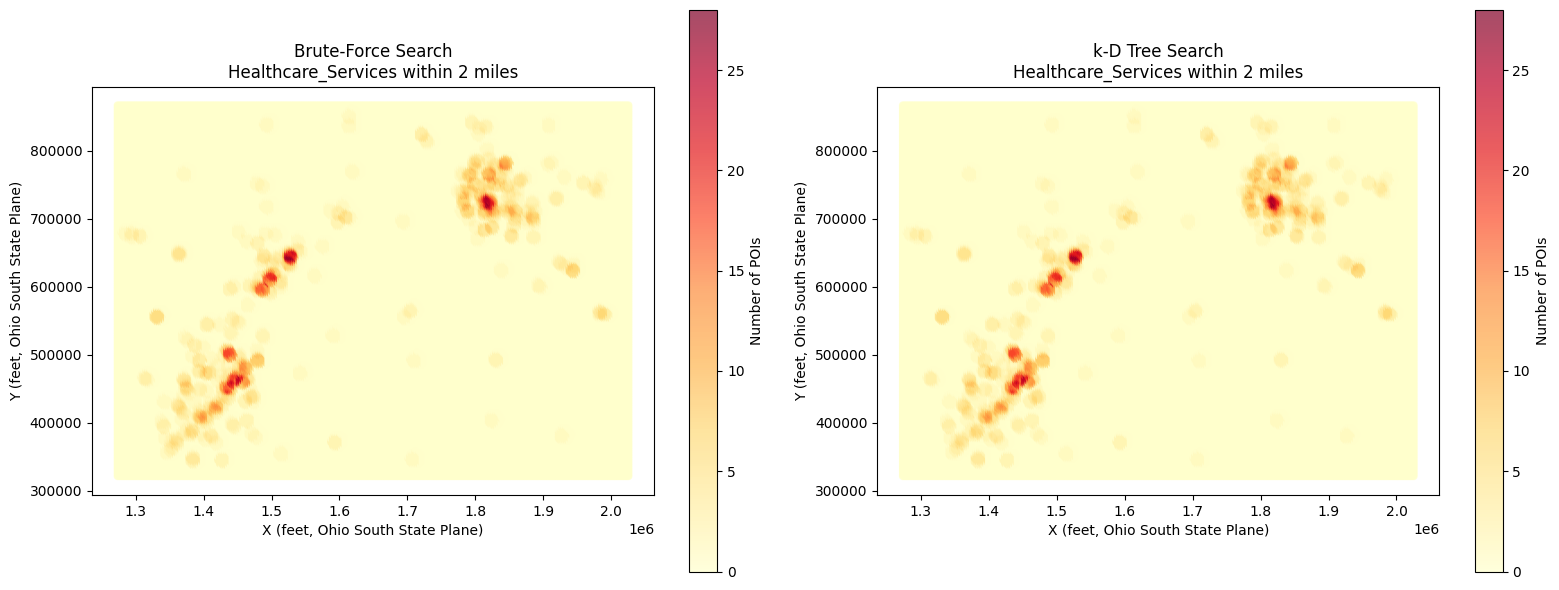

Maps displayed


In [ ]:

grid_x = [cell[0] for cell in grid_cells]
grid_y = [cell[1] for cell in grid_cells]

print("\nQuestion 4: Creating accessibility maps")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = ax1.scatter(grid_x, grid_y, c=brute_force_results,
                       cmap='YlOrRd', s=20, alpha=0.7)
ax1.set_title(f'Brute-Force Search\n{CHOSEN_SUPER_TYPE} within 2 miles')
ax1.set_xlabel('X (feet, Ohio South State Plane)')
ax1.set_ylabel('Y (feet, Ohio South State Plane)')
ax1.set_aspect('equal')
plt.colorbar(scatter1, ax=ax1, label='Number of POIs')

scatter2 = ax2.scatter(grid_x, grid_y, c=kdtree_results,
                       cmap='YlOrRd', s=20, alpha=0.7)
ax2.set_title(f'k-D Tree Search\n{CHOSEN_SUPER_TYPE} within 2 miles')
ax2.set_xlabel('X (feet, Ohio South State Plane)')
ax2.set_ylabel('Y (feet, Ohio South State Plane)')
ax2.set_aspect('equal')
plt.colorbar(scatter2, ax=ax2, label='Number of POIs')

plt.tight_layout()
plt.show()

print("Maps displayed")

##Question 5: Finding best accessibility
Identify which grid cells have access to the most healthcare POIs within 2 miles.

In [ ]:
max_count = max(kdtree_results)

max_indices = []
for i in range(len(kdtree_results)):
    if kdtree_results[i] == max_count:
        max_indices.append(i)

max_cells = [grid_cells[i] for i in max_indices]

print(f"\nQuestion 5: Cells with highest accessibility")
print(f"Maximum POIs accessible: {max_count}")
print(f"Number of cells with maximum: {len(max_cells)}")
print(f"Coordinates (Ohio South State Plane, feet):")
for i, cell in enumerate(max_cells, 1):
    print(f"  Cell {i}: X = {cell[0]:.2f}, Y = {cell[1]:.2f}")


Question 5: Cells with highest accessibility
Maximum POIs accessible: 28
Number of cells with maximum: 1
Coordinates (Ohio South State Plane, feet):
  Cell 1: X = 1531969.49, Y = 643069.12


##Question 6: Identifying low-access areas


Count how many cells have poor healthcare access (3 or fewer POIs within 2 miles).

In [ ]:
low_access_count = 0
for count in kdtree_results:
    if count <= 3:
        low_access_count += 1

print(f"\nQuestion 6: Low accessibility analysis")
print(f"Cells with 3 or fewer POIs: {low_access_count}")
print(f"Percentage: {100 * low_access_count / len(grid_cells):.1f}%")


Question 6: Low accessibility analysis
Cells with 3 or fewer POIs: 56609
Percentage: 95.2%
